In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
print("="*60)
print("步骤1: 读取数据")
print("="*60)

步骤1: 读取数据


In [5]:
# 1. 读取数据 - 请修改为你的文件名
df = pd.read_csv('adsorption_co2.csv') 

In [6]:
print(f"数据形状: {df.shape}")
print(f"\n前5行数据:")
print(df.head())
print(f"\n数据类型:")
print(df.dtypes)
print(f"\n缺失值统计:")
print(df.isnull().sum())

数据形状: (1000, 24)

前5行数据:
         name  _cell_length_a  _cell_length_b  _cell_length_c  \
0  hMOF-30983       16.992694        8.559649       15.455313   
1  hMOF-12046       19.077105       12.759394       19.076929   
2    hMOF-907       12.759401       12.759400       12.759393   
3  hMOF-30728        9.065218        8.597304        7.540329   
4  hMOF-28290       10.654550       16.109301        9.130313   

   _cell_angle_alpha  _cell_angle_beta  _cell_angle_gamma   lcd   pld  \
0          92.289439         87.142206          80.223444  4.75  3.75   
1          92.271260         90.078300          87.711291  6.25  4.75   
2          90.031564         89.981504          89.985155  9.25  7.75   
3          82.296522         89.996962          85.172810  6.25  5.25   
4          89.994060         89.999724          83.973206  6.75  6.25   

   void_fraction  ...  number_N  number_O  number_F  number_Cl  number_V  \
0       0.461963  ...        12        16         0         18       

In [7]:
print("\n" + "="*60)
print("步骤2: 数据预处理")
print("="*60)


步骤2: 数据预处理


In [8]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print(f"数值型列数量: {len(numeric_columns)}")
print(f"分类型列数量: {len(categorical_columns)}")

数值型列数量: 23
分类型列数量: 1


In [9]:
#  处理异常值(使用IQR方法)
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower_bound, upper_bound)

print("异常值处理完成")

异常值处理完成


In [10]:
# 2.4 编码分类变量
target_column = df.columns[-1]
print(f"\n目标变量: {target_column}")


目标变量: adsorption


In [11]:
# 对非目标变量的分类列进行编码
label_encoders = {}
encoded_count = 0
for col in categorical_columns:
    if col != target_column:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        encoded_count += 1
        print(f"✓ 已编码第{encoded_count}个: {col} (唯一值数量: {len(le.classes_)})")

if encoded_count == 0:
    print("⚠ 警告: 没有需要编码的分类列(除目标变量外)")

✓ 已编码第1个: name (唯一值数量: 1000)


In [12]:
# 如果目标变量也是分类型,也需要编码
if target_column in categorical_columns:
    le_target = LabelEncoder()
    df[target_column] = le_target.fit_transform(df[target_column].astype(str))
    print(f"✓ 已编码目标变量: {target_column} (类别数: {len(le_target.classes_)})")
    print(f"  类别映射: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
print("\n" + "="*60)
print("步骤3: 划分特征和目标变量")
print("="*60)


步骤3: 划分特征和目标变量


In [13]:
# 5. 分离特征和目标变量
X = df.drop(target_column, axis=1)
y = np.log1p(df[target_column])

In [14]:
print(f"特征数量: {X.shape[1]}")
print(f"样本数量: {X.shape[0]}")
print(f"目标变量分布:\n{y.value_counts()}")

特征数量: 23
样本数量: 1000
目标变量分布:
adsorption
0.000000    38
1.794872    30
1.566261     1
0.720417     1
0.778898     1
            ..
0.848166     1
0.492989     1
0.800350     1
1.335640     1
1.063586     1
Name: count, Length: 934, dtype: int64


In [15]:
print("\n" + "="*60)
print("步骤4: 划分训练集和测试集 (8:2)")
print("="*60)


步骤4: 划分训练集和测试集 (8:2)


In [16]:
# 6. 划分训练集和测试集
# 检查是否可以使用分层采样
min_class_count = y.value_counts().min()

In [17]:
if min_class_count >= 2:
    print("使用分层采样...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )
else:
    print("使用普通随机采样...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )

使用普通随机采样...


In [18]:
print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")

训练集大小: (800, 23)
测试集大小: (200, 23)


In [19]:
# 7. 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# 转换回DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
print("特征标准化完成")

特征标准化完成


In [21]:
print("\n" + "="*60)
print("步骤5: XGBoost模型训练")
print("="*60)


步骤5: XGBoost模型训练


In [22]:
# 8. 判断任务类型
n_unique = len(y.unique())
is_classification = n_unique < 20

In [23]:
if is_classification:
    print(f"任务类型: 分类 (共{n_unique}个类别)")
    task_type = 'classification'
else:
    print(f"任务类型: 回归 (共{n_unique}个唯一值)")
    task_type = 'regression'

任务类型: 回归 (共934个唯一值)


In [24]:
# 9. 模型优化 - 使用网格搜索找最佳参数
from sklearn.model_selection import GridSearchCV, cross_val_score

print("\n" + "="*60)
print("开始模型优化...")
print("="*60)


开始模型优化...


In [25]:
model_fixed = xgb.XGBRegressor(
        n_estimators=2000,
        max_depth=6,
        learning_rate=0.035,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.5,
        random_state=42,
        eval_metric='rmse'
    )

In [26]:
print("训练固定参数模型...")
model_fixed.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)


训练固定参数模型...


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [27]:
y_train_pred_fixed = model_fixed.predict(X_train_scaled)
y_test_pred_fixed = model_fixed.predict(X_test_scaled)

In [28]:
if task_type == 'regression':
    from sklearn.metrics import mean_squared_error, r2_score

In [29]:
    train_r2_fixed = r2_score(y_train, y_train_pred_fixed)
    test_r2_fixed = r2_score(y_test, y_test_pred_fixed)

In [30]:
print("\n" + "="*60)
print("步骤6: 模型预测与评估")
print("="*60)


步骤6: 模型预测与评估


In [31]:
# 10. 预测
y_train_pred = model_fixed.predict(X_train_scaled)
y_test_pred = model_fixed.predict(X_test_scaled)

In [32]:
# 11. 评估
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

✓ 预测散点图已保存: prediction_scatter.png


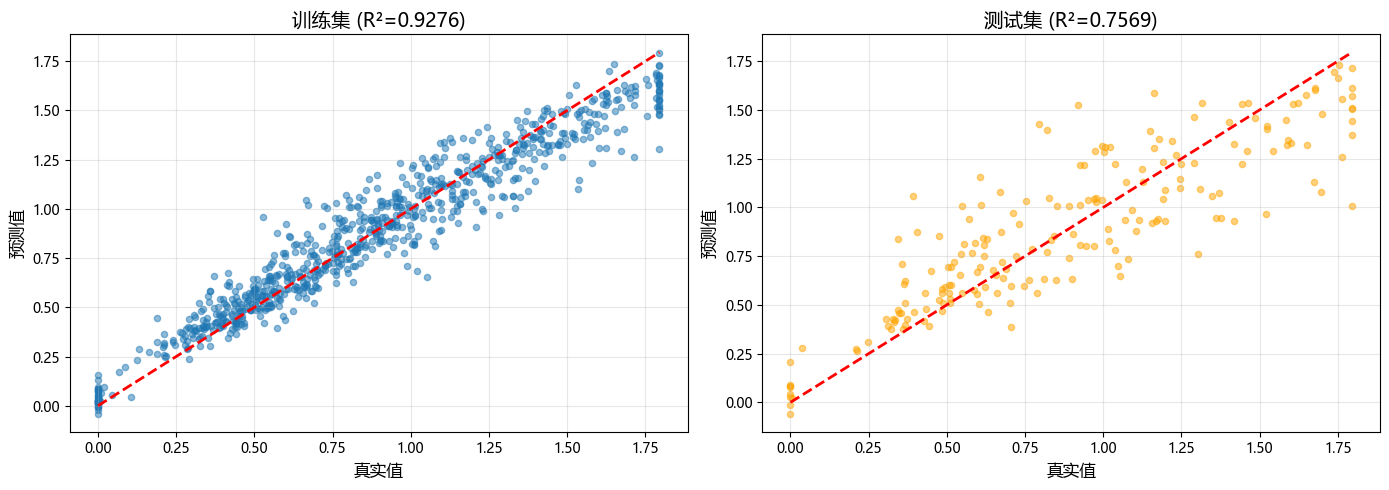

In [33]:
# 预测值 vs 真实值散点图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 训练集
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('真实值', fontsize=12)
axes[0].set_ylabel('预测值', fontsize=12)
axes[0].set_title(f'训练集 (R²={train_r2:.4f})', fontsize=14)
axes[0].grid(True, alpha=0.3)

# 测试集
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('真实值', fontsize=12)
axes[1].set_ylabel('预测值', fontsize=12)
axes[1].set_title(f'测试集 (R²={test_r2:.4f})', fontsize=14)
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_scatter.png', dpi=300, bbox_inches='tight')
print("✓ 预测散点图已保存: prediction_scatter.png")
plt.show()

✓ 残差图已保存: residual_plot.png


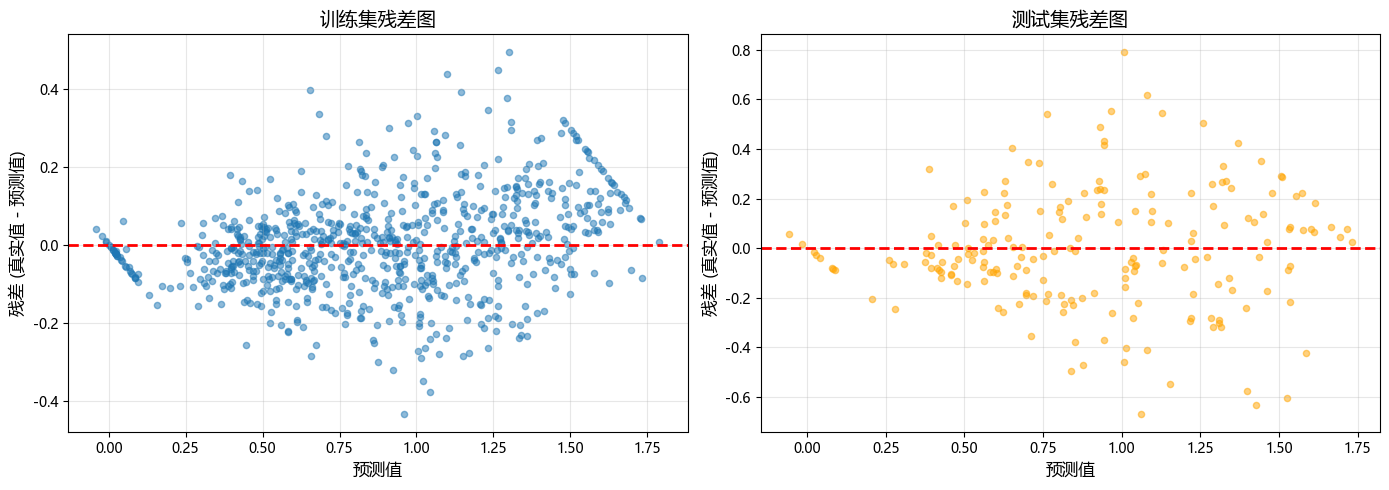

In [34]:
# 残差图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# 训练集残差
axes[0].scatter(y_train_pred, train_residuals, alpha=0.5, s=20)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('预测值', fontsize=12)
axes[0].set_ylabel('残差 (真实值 - 预测值)', fontsize=12)
axes[0].set_title('训练集残差图', fontsize=14)
axes[0].grid(True, alpha=0.3)

# 测试集残差
axes[1].scatter(y_test_pred, test_residuals, alpha=0.5, s=20, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('预测值', fontsize=12)
axes[1].set_ylabel('残差 (真实值 - 预测值)', fontsize=12)
axes[1].set_title('测试集残差图', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_plot.png', dpi=300, bbox_inches='tight')
print("✓ 残差图已保存: residual_plot.png")
plt.show()

In [35]:
print("\n" + "="*60)
print("步骤7: 特征重要性分析")
print("="*60)


步骤7: 特征重要性分析


In [36]:
# 12. 特征重要性
feature_importance = model_fixed.feature_importances_
importance_df = pd.DataFrame({
    '特征': X.columns,
    '重要性': feature_importance
}).sort_values('重要性', ascending=False)

print("\n特征重要性排名(前10):")
print(importance_df.head(10))


特征重要性排名(前10):
                    特征       重要性
8                  pld  0.213331
9        void_fraction  0.138861
10    surface_area_m2g  0.136068
12            number_H  0.080771
7                  lcd  0.063757
11  surface_area_m2cm3  0.051872
0                 name  0.038496
19           number_Cu  0.032614
13            number_C  0.031784
14            number_N  0.029397


✓ 特征重要性图已保存: feature_importance.png


<Figure size 1000x600 with 0 Axes>

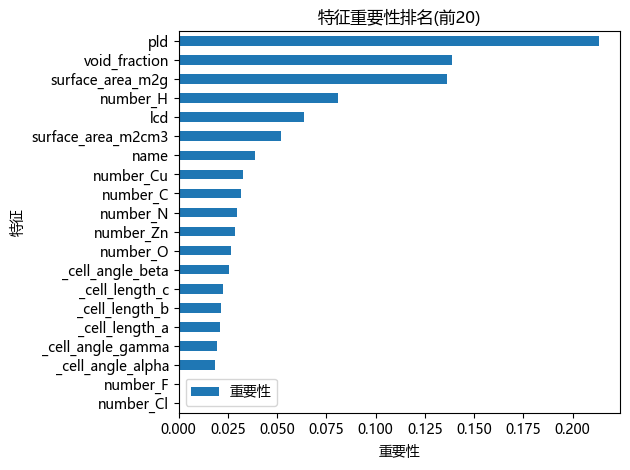

In [37]:
# 可视化
plt.figure(figsize=(10, 6))
top_n = min(20, len(importance_df))
importance_df.head(top_n).plot(x='特征', y='重要性', kind='barh')
plt.xlabel('重要性')
plt.title(f'特征重要性排名(前{top_n})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ 特征重要性图已保存: feature_importance.png")
plt.show()

In [38]:
print("\n" + "="*60)
print("步骤8: 保存结果")
print("="*60)


步骤8: 保存结果


In [39]:
# 13. 保存模型
model_fixed.save_model('xgboost_model.json')
print("✓ 模型已保存: xgboost_model.json")

✓ 模型已保存: xgboost_model.json


In [40]:
# 14. 保存预测结果
results_df = pd.DataFrame({
    '真实值': y_test.values,
    '预测值': y_test_pred
})

results_df.to_csv('predictions.csv', index=False, encoding='utf-8-sig')
print("✓ 预测结果已保存: predictions.csv")

✓ 预测结果已保存: predictions.csv


In [41]:
# 15. 保存训练集和测试集
train_data = X_train_scaled.copy()
train_data[target_column] = y_train.values
test_data = X_test_scaled.copy()
test_data[target_column] = y_test.values

train_data.to_csv('train_set.csv', index=False, encoding='utf-8-sig')
test_data.to_csv('test_set.csv', index=False, encoding='utf-8-sig')
print("✓ 训练集已保存: train_set.csv")
print("✓ 测试集已保存: test_set.csv")

✓ 训练集已保存: train_set.csv
✓ 测试集已保存: test_set.csv


In [42]:
print("\n" + "="*60)
print("🎉 全部流程完成!")
print("="*60)


🎉 全部流程完成!
